In [1]:
import json
import Levenshtein as lv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [13]:
def measure_time_distance(timedelta):
    """
    Function that convert timedelta into seconds
    """
    distance = (timedelta.total_seconds())
    return distance

def measure_text_distance(x,y):
    """
    Function that calculate the Levenshtein distance
    between two submissions code.
    https://en.wikipedia.org/wiki/Levenshtein_distance
    """
    return lv.distance(x,y)

def calculate_distribution(df, column_name, exercise, mean=True):
    """
    df: Dataframe with submissions
    column_name: column with status

    Function to obtain distribution of submissions status
    return metrics and amount of submissions
    """
    total_amount_submissions = df.shape[0]
    submissions_grouped = df.groupby([column_name]).size()
    metrics = {}
    if mean:
        metrics = submissions_grouped/total_amount_submissions
    else:
        metrics = submissions_grouped
    metrics['exercise'] = str(exercise)
    metrics['submission_amount'] = total_amount_submissions
    return metrics

def shift_columns(df, shift_social=False):
    """
    Function that create 4 new columns
    shifted column contains submissions_content shifted to calculate the distance
    datetime_shifted contains datetime shifted to calculate the distance between times
    
    distance, Levenshtein distance between submissions
    time_dist, time distance between submissions in seconds
    """
    df.loc[:,'shifted'] = df['content'].shift().fillna(value='')
    df.loc[:,'guide.name.previous'] = df['guide.name'].shift().fillna(value='')
    df.loc[:,'datetime_shifted'] = df['datetime'].shift().fillna(value=pd.Timestamp(1800, 1, 1, 0))
    df.loc[:,'student.email.previous'] = df['student.email'].shift().fillna(value='')
    df['distance'] = df.apply(lambda x : measure_text_distance(x['content'],x['shifted']), axis=1)
    df['time_dist'] = df.apply(lambda x : measure_time_distance(x['datetime']-x['datetime_shifted']), axis=1)
    df.loc[:,'exercise.eid.previous'] = df['exercise.eid'].shift().fillna(value='')
    df.loc[:,'exercise.name.previous'] = df['exercise.name'].shift().fillna(value='')
    df.loc[:,'submissions_status.previous'] = df['submissions_status'].shift().fillna(value='')
    df.loc[:,'submissions_count.previous'] = df['submissions_count'].shift().fillna(value='')
    df['switch_exercise'] = df.apply(lambda x : x['exercise.name'] != x['exercise.name.previous'], axis=1)
    if shift_social:
        df['submitter.social_id.previous'] = df['submitter.social_id'].shift().fillna(value='')
        
    return df

def plot_time_between_submissions(dic, time_max):
    plt.gcf().clear()
    plt.style.use('seaborn')
    plt.figure("Time between submissions", figsize=(30,15))
    plt.title("Tiempo entre soluciones", size=26)
    plt.bar(list(dic.keys()), height=list(dic.values()), edgecolor='black', label='Cantidad de submissions', width=4)

    #ticks = np.arange(10, time_max, 10)
    #plt.xticks(rotation=70)
    #plt.xticks(ticks, ticks, size=13)

    plt.xlabel('Tiempo (en segundos)', size=18)
    plt.ylabel('Cantidad de submissions', size=18)
    plt.legend()
    plt.show()

### Load Dataset
Load dataset, normalize and expand nested json with submissions to obtain a plain dataframe with one submission in each row.

Before, create a column named as 'datetime' with the date and time of the submission.

Finally remove all the null content submissions because these will cause problems in processings.

In [3]:
dataset_home = "datasets/"
json_file = open(dataset_home + '2018-2c-introalgo-2018-2c.json', encoding='utf8')
json_data = json.load(json_file)
submissions = pd.io.json.json_normalize(
      json_data, 'submissions', [['guide','slug'], ['student','email'],['guide','name'], ['exercise','name'],['exercise','eid'],['guide','language','name']], record_prefix='submissions_', errors='ignore')
submissions['datetime'] = pd.to_datetime(submissions['submissions_created_at'])
submissions = submissions[~submissions['submissions_content'].isnull()]
submissions = submissions[~(submissions['submissions_status']=='aborted')]
submissions = submissions[submissions['guide.language.name'] == 'haskell']
submissions = submissions.drop(
    submissions[(submissions['student.email'] == 'walteralini@gmail.com') |
                (submissions['student.email'] == 'romina.altamirano@gmail.com') |
                (submissions['student.email'] == 'kouichicruz@gmail.com')].index)
submissions = submissions.drop(
    submissions[(submissions['student.email'] == 'ismaelpeker@gmail.com') &
                (submissions['submissions_created_at'].str.contains('2017'))].index)
short_submissions_df = submissions[['submissions_content','datetime','exercise.name', 'student.email']]

In [4]:
mem_big = submissions.memory_usage(index=True).sum()
mem_short = short_submissions_df.memory_usage(index=True).sum()
print("Mem usage with full df {}".format(mem_big))
print("Mem usage with short df {}".format(mem_short))

print("Proportion between df {}".format(mem_short/mem_big))

Mem usage with full df 2637856
Mem usage with short df 775840
Proportion between df 0.29411764705882354


### Only for dive into dataset
show status distribution

In [18]:
import os
#os.listdir('dataframes_pkl/failed_submissions_df.pkl')
# submissions = pd.read_pickle('dataframes_pkl/introAlgo_FINAL_anotado.pkl')
submissions = pd.read_pickle('dataframes_pkl/mumuki_io_FINAL_anotado.pkl')

In [19]:
calculate_distribution(submissions, 'submissions_status', 'todos', False)

submissions_status
errored                  69249
failed                   86525
passed                   68106
passed_with_warnings     11821
exercise                 todos
submission_amount       235701
dtype: object

In [46]:
calculate_distribution(submissions, 'submissions_status', 'IntroAlgo 2018', mean=False)

submissions_status
errored                           7459
failed                            7874
passed                            3271
passed_with_warnings               792
exercise                IntroAlgo 2018
submission_amount                19396
dtype: object

### Important thing is done below
Calculate time between submissions by exercise and student.
Only calculate for exercises with more than one submissions done.
One thing that u have to consider, the time diference between first submissions is calculated subtracting it with 1-1-1800.
So it is easiest way to figure out which is the time difference that u have not consider as a valid time difference.


In [74]:
submissions.columns

Index(['content', 'guide.name', 'datetime', 'student.email', 'distance',
       'time_dist', 'exercise.eid', 'exercise.name', 'submissions_status',
       'submissions_count', 'switch_exercise', 'dropout_switch',
       'dropout_session', 'dropout_session_tray', 'dropout_switch_tray',
       'dropout', 'dropout_tray', 'PSA', 'PCA', 'PCAM', 'PA', 'EA', 'PPA',
       'PTT', 'PDL', 'IPA', 'PCSA', 'APE', 'CAPE', 'COMP'],
      dtype='object')

In [20]:
#para mumukio
#submissions = submissions.sort_values(['student.email', 'datetime'])
#submissions = shift_columns(submissions, True)
#para introAlgo
submissions = submissions.sort_values(['student.email', 'datetime'])
submissions = shift_columns(submissions, False)

In [6]:
#only to show
#submissions[(submissions['student.email'] == submissions['student.email.previous'])][['student.email', 'student.email.previous', 'time_dist']].sort_values('time_dist', ascending=False)
#submissions[(submissions['student.email'] == submissions['student.email.previous']) |(submissions['submitter.social_id'] == submissions['submitter.social_id.previous'])][['student.email', 'student.email.previous', 'time_dist']].sort_values('time_dist', ascending=False)#['time_dist']

### another important task is donde below
First of all, sort time differences calculated previously ascending, round it (in the furture probably we dont want to round it).
Before that count the differences times ocurrences. 

In [52]:
#submissions = submissions[(submissions['student.email'] == submissions['student.email.previous']) | 
#                         (submissions['submitter.social_id'] == submissions['submitter.social_id.previous'])]
#introalgo
submissions = submissions[submissions['student.email'] == submissions['student.email.previous']]

In [21]:
## Despliego todos los tiempos para poder tomar los percentiles
df = submissions.sort_values(ascending=True, by='time_dist').round()['time_dist'].to_frame()
df = df[df['time_dist'] >= 0].reset_index(drop=True)['time_dist'].to_frame()
df

,time_dist
0,0.000000e+00
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,0.000000e+00
7,0.000000e+00
8,0.000000e+00
9,0.000000e+00


In [22]:
print('Total times {}'.format(df.shape[0]))
print('Quantile %95 time {}.'.format(df.quantile(0.95)[0]))
print('Quantile %90 time {}.'.format(df.quantile(0.90)[0]))
print('Quantile %85 time {}.'.format(df.quantile(0.85)[0]))
print('Quantile %80 time {}'.format(df.quantile(0.80)[0]))

Total times 233537
Quantile %95 time 5937.0.
Quantile %90 time 623.0.
Quantile %85 time 299.0.
Quantile %80 time 194.0


In [55]:
df.quantile(.90)

time_dist    454.0
Name: 0.9, dtype: float64

### 95 percentage

/home/mrc/anaconda3/envs/mumuki/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


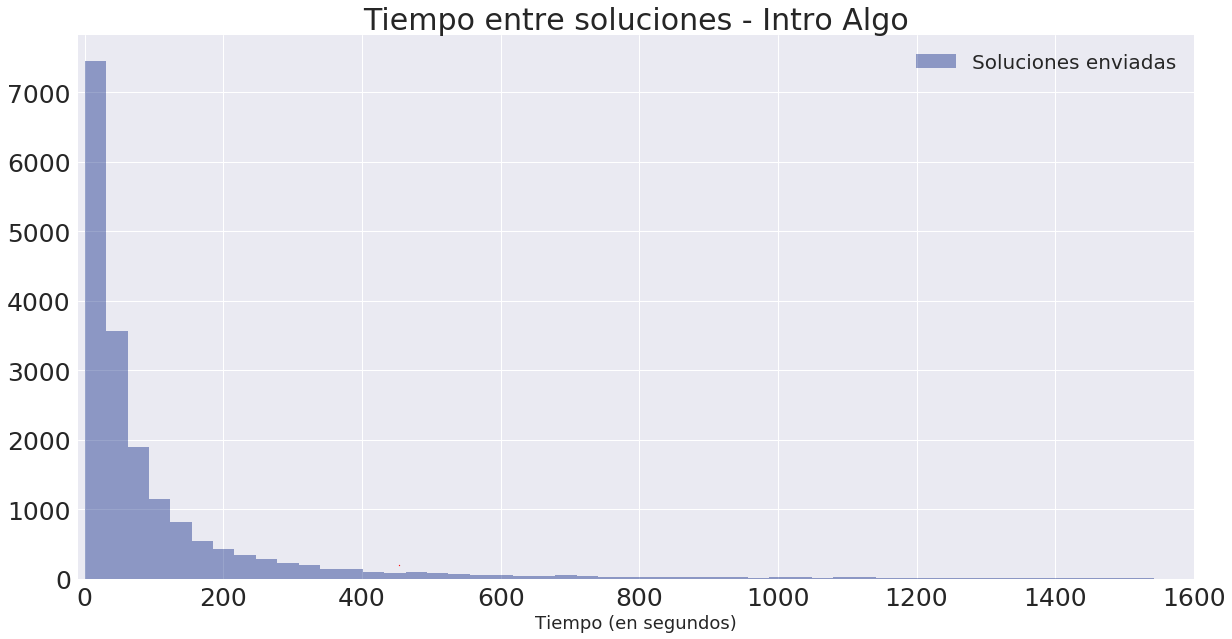

In [17]:
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
sb.set()
sb.set_palette(sb.color_palette("dark", 100))
plt.figure(figsize=(20,10))
#plt.xlim(-10,1600)
sb.distplot(df.loc[:18336, :],kde = False, label='Soluciones enviadas')

plt.title('Tiempo entre soluciones - Intro Algo', size=30)
plt.xlabel('Tiempo (en segundos)', size=18)
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlim(-10,1600)
#plt.ylabel('Cantidad de submissions', size=18)
plt.scatter([454],[200], color='red', s=1)
plt.legend(prop={'size': 20})
             
plt.show()


In [104]:
df[df['time_dist'] == 1541]
#df.loc[:1493, :]

,time_dist
18336,1541.0
